> Date: 20190310
>
> By Lyndon Chen Luo

In [58]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
import os

In [4]:
print(os.getcwd())

/Users/lyndon/PycharmProjects/corruption


## 标注数据拆分

- 先把原始数据拆分：训练集(80%)、验证集/评估集(20%)

- 方法：随机抽样

In [5]:
import pandas as pd

In [6]:
trainingSetAll = './trainingSet.csv'
data = pd.read_csv(trainingSetAll, sep='|', header=0)
data.head()

,Unnamed: 0,content,type
0,0,道真县违法建筑导致今天的局面，乃是政府严重不作为所形成的。现在搞得人不聊生，人民怨声载道。恳...,不作为
1,1,我于2009年11月买的城市广场房子，协议上提示2010年8月31日前交房，可是到目前为止，...,不作为
2,2,目前整个山盆镇大大小小的麻将馆不计其数。其中山盆镇上还有一家赌博游戏机。这些赌博场所有大量的...,不作为
3,3,肖书记，您好，地方留言我以看了很多，为什么其他城市对民生的留言回答得很快，我们道真关天民生问...,不作为
4,4,尊敬的遵义县委书记： 新舟机场的开通加速了遵义市及各县区的经济发展，然而，日益猖獗的非...,不作为


In [7]:
# 随机抽样：抽取20%的数据作为验证集
validationSet = data.sample(frac=0.2, replace=False, random_state=311, axis=0)

In [8]:
type(validationSet)

pandas.core.frame.DataFrame

In [11]:
validationSet.shape

(12356, 3)

In [9]:
validationSet.to_csv('./validationSet.csv', sep='|', index=None)

In [10]:
# 摘选出另外的80%
validation = pd.read_csv('./validationSet.csv', sep='|', header=0)
trainingTrue = data.drop(list(validation['Unnamed: 0']))
trainingTrue.shape

(49426, 3)

In [12]:
trainingTrue.to_csv('./trainingSetTrue.csv', sep='|', index=None, header=True)

## 训练模型

In [13]:
# 特征提取类库
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# 模型类库
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# 模型输出结果类库
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# 模型选择类库
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# 模型集成类库
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# 模型可视化类库
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
# 训练集分词，存成新文件
import jieba

trainingSetTrue = pd.read_csv('./trainingSetTrue.csv', sep='|', header=0)

def seg(text):
    _ = list()
    for word in list(jieba.cut(str(text))):
        if len(word) > 1:
            _.append(word.strip())
    return _

In [16]:
trainingSetTrue['segmentation'] = trainingSetTrue['content'].apply(seg)
trainingSetTrueSeg = trainingSetTrue[['segmentation', 'type']]
trainingSetTrueSeg.to_csv('./trainingSetTrueSeg.csv', sep='|', index=None)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/_6/73bms9_11733g1hbd2_jmrzc0000gn/T/jieba.cache
Loading model cost 0.762 seconds.
Prefix dict has been built succesfully.


In [17]:
# 导入分词后的训练集
dataset_train = pd.read_csv('./trainingSetTrueSeg.csv', sep='|', index_col=None)
dataset_train.head()

,segmentation,type
0,"['真县', '违法', '建筑', '导致', '今天', '局面', '乃是', '政府...",不作为
1,"['我于', '2009', '11', '城市', '广场', '房子', '协议', '...",不作为
2,"['目前', '整个', '山盆镇', '大大小小', '麻将馆', '不计其数', '其中...",不作为
3,"['尊敬', '遵义', '县委书记', '新舟', '机场', '开通', '加速', '...",不作为
4,"['曾经', '当过兵', '正在', '部队', '服役', '战友', '朋友', '大...",不作为


In [19]:
# 计算词频
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dataset_train['segmentation'])
print(X_train_counts.shape)
# print(count_vect.get_feature_names())

(49426, 141249)


In [32]:
# 计算 TF-IDF（后续分词用 TF-IDF 文本特征）
tf_transformer = TfidfVectorizer(max_df=0.99, min_df=0.001)
X_train_counts_tf = tf_transformer.fit_transform(dataset_train['segmentation'])
print(X_train_counts_tf.shape)

(49426, 6801)


/Users/lyndon/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [28]:
# 查看特征
# print(tf_transformer.get_feature_names())

['10', '12', '20', '2013', '2014', '30', '一下', '一个', '一些', '一名', '一年', '一直', '不到', '不是', '不管', '不能', '不要', '业主', '严重', '为了', '为什么', '举报', '书记', '乱收费', '事情', '人员', '人民', '人民网', '什么', '今年', '他们', '以上', '任何', '但是', '住户', '作为', '你们', '你好', '做主', '公司', '关于', '关注', '关系', '其他', '农村', '农民', '利益', '办法', '办理', '单位', '去年', '反应', '反映', '发展', '只有', '可以', '可是', '回复', '因为', '国家', '土地', '地方', '处理', '多少', '多次', '如果', '存在', '学校', '学生', '孩子', '安全', '导致', '尊敬', '小区', '就是', '居民', '属于', '工作', '工程', '已经', '市长', '希望', '干部', '并且', '应该', '建设', '开发商', '开始', '当地', '当时', '影响', '很多', '得到', '怎么', '恳请', '您好', '情况', '我们', '房子', '房屋', '所以', '所有', '投诉', '拆迁', '按照', '收取', '收费', '政府', '政策', '教育', '无法', '时候', '时间', '是不是', '是否', '有关', '村民', '村里', '来源', '标准', '根本', '正常', '此事', '每天', '没有', '物业', '环境', '现在', '现象', '生活', '由于', '留言板', '百姓', '百忙之中', '相关', '省长', '看到', '知道', '社会', '答复', '管理', '结果', '给予', '群众', '老百姓', '而且', '能够', '腐败', '自己', '至今', '行为', '补偿', '补偿款', '要求', '规定', '解决', '请问', '调查', '谢谢', '贪污', '费用', '过问', '还是', '还有', '

In [21]:
# 评估算法：10-Folds 交叉验证
num_folds, seed, scoring = 10, 7, 'accuracy'

In [34]:
# 生成算法模型（暂用默认参数，后期调整）
models = dict()
models['LR'] = LogisticRegression()
models['MNB'] = MultinomialNB()
models['KNN'] = KNeighborsClassifier()
# models['SVM'] = SVC()
models['CART'] = DecisionTreeClassifier()

In [35]:
# 算法比较
results = []
for key in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(models[key], X_train_counts_tf, dataset_train.type, cv=kfold, scoring=scoring)
    results.append(cv_results)
    # 模型 MSE's mean & std
    print('%s: %f (%f)'%(key, cv_results.mean(), cv_results.std()))

LR: 0.890993 (0.080647)
MNB: 0.775898 (0.181182)
KNN: 0.482790 (0.279739)
CART: 0.906650 (0.038499)


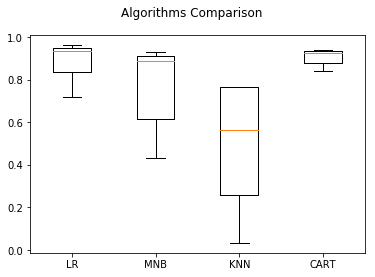

In [36]:
# 展现算法结果
fig = plt.figure()
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
plt.show()

- 对 Logistic Regression 和 Classification & Regression Tree 做进一步优化

In [40]:
# Logistic 调参
param_grid = dict()
param_grid['C'] = [5, 13, 15, 20, 25]
model = LogisticRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X=X_train_counts_tf, y=dataset_train.type)
print(grid_result.cv_results_['mean_test_score'])
print('Best: %s, Using: %s'%(grid_result.best_score_, grid_result.best_params_))

[0.9108364  0.91203011 0.91184802 0.91227289 0.91132198]
Best: 0.9122728928094526, Using: {'C': 20}


In [43]:
# CART 调参
param_grid = dict()
param_grid['criterion'] = ('gini', 'entropy')
param_grid['max_features'] = ('auto', 'sqrt', 'log2', None)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X=X_train_counts_tf, y=dataset_train.type)
print(grid_result.cv_results_['params'], '\n', grid_result.cv_results_['mean_test_score'])
print('Best: %s, Using: %s'%(grid_result.best_score_, grid_result.best_params_))

[{'criterion': 'gini', 'max_features': 'auto'}, {'criterion': 'gini', 'max_features': 'sqrt'}, {'criterion': 'gini', 'max_features': 'log2'}, {'criterion': 'gini', 'max_features': None}, {'criterion': 'entropy', 'max_features': 'auto'}, {'criterion': 'entropy', 'max_features': 'sqrt'}, {'criterion': 'entropy', 'max_features': 'log2'}, {'criterion': 'entropy', 'max_features': None}] 
 [0.79067697 0.77768786 0.67567677 0.90583903 0.78171408 0.78697447
 0.68091693 0.91852466]
Best: 0.9185246631327642, Using: {'criterion': 'entropy', 'max_features': None}


## 集成算法测试
- Bagging (RF) & Boosting (AdaBoost)

In [46]:
ensembles = dict()
ensembles['RF'] = RandomForestClassifier()
ensembles['AB'] = AdaBoostClassifier()

results = list()
for key in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(ensembles[key], X_train_counts_tf, dataset_train.type, cv=kfold, scoring=scoring)
    results.append(cv_results)
    print('%s: %f (%f)'%(key, cv_results.mean(), cv_results.std()))

RF: 0.883950 (0.039638)
AB: 0.926054 (0.051752)


In [47]:
results

[array([0.82743273, 0.8359296 , 0.81428282, 0.90714141, 0.90390451,
        0.9261582 , 0.91622825, 0.88972076, 0.92108458, 0.8976123 ]),
 array([0.85150718, 0.85251871, 0.84220109, 0.93141817, 0.95731337,
        0.96560793, 0.956293  , 0.96863618, 0.97248078, 0.96256576])]

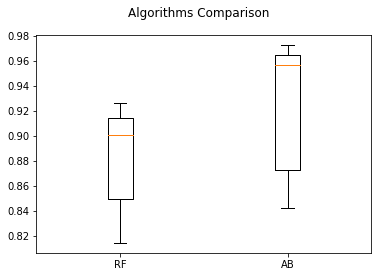

In [49]:
fig = plt.figure()
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(ensembles.keys())
plt.show()

In [50]:
# 对 AdaBoost 进行调参
param_grid = dict()
param_grid['n_estimators'] = [10, 50, 100, 150, 200]
model = AdaBoostClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X=X_train_counts_tf, y=dataset_train.type)
print(grid_result.cv_results_['params'], '\n', grid_result.cv_results_['mean_test_score'])
print('Best: %s, Using: %s'%(grid_result.best_score_, grid_result.best_params_))

[{'n_estimators': 10}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 150}, {'n_estimators': 200}] 
 [0.87571319 0.92605107 0.93440699 0.93734067 0.93877716]
Best: 0.9387771618176668, Using: {'n_estimators': 200}


> 模型对比
>
> - Logistic Regression (C = 20), 0.9123
>
> - CART (criterion: entropy, max_features: none), 0.9185
>
> - AdaBoost (n_estimators: 100)  0.9344 之后增长速度变缓

## 模型准确度验证

In [51]:
validationSet = pd.read_csv('./validationSet.csv', header=0, sep='|')
validationSet.head()

,Unnamed: 0,content,type
0,33185,我们全家4人于2016年2月15日去云南丽江玉龙雪山旅游，在山门口售票处被告知除每人130的...,贪腐
1,9198,尊敬的黄书记，金牛区银河路一号天鑫花园西区3幢4、5、6单元的违章搭建及非法经营的麻馆我们已...,不作为
2,47929,尊敬的张书记您好！ 在您百忙之中打扰了，实在没有办法，我的孩子2011年9月份上龙华中...,贪腐
3,58663,灵石一中去年高三开设补习班，未达录取线的孩子根据分数不同分别收取补习费，最低500元，最高为...,贪腐
4,38195,5月30日，大竹县庙坝镇新桥小学（庙坝镇二小）老师杨万得，在庙坝镇新桥街上办生日宴，办席规模...,贪腐


In [52]:
validationSet['segmentation'] = validationSet['content'].apply(seg)
validationSet.head()

,Unnamed: 0,content,type,segmentation
0,33185,我们全家4人于2016年2月15日去云南丽江玉龙雪山旅游，在山门口售票处被告知除每人130的...,贪腐,"[我们, 全家, 人于, 2016, 15, 日去, 云南, 丽江, 玉龙雪山, 旅游, 门..."
1,9198,尊敬的黄书记，金牛区银河路一号天鑫花园西区3幢4、5、6单元的违章搭建及非法经营的麻馆我们已...,不作为,"[尊敬, 书记, 金牛区, 银河, 一号, 天鑫, 花园, 西区, 单元, 违章, 搭建, ..."
2,47929,尊敬的张书记您好！ 在您百忙之中打扰了，实在没有办法，我的孩子2011年9月份上龙华中...,贪腐,"[尊敬, 书记, 您好, 百忙之中, 打扰, 实在, 没有, 办法, 孩子, 2011, 月..."
3,58663,灵石一中去年高三开设补习班，未达录取线的孩子根据分数不同分别收取补习费，最低500元，最高为...,贪腐,"[灵石, 一中, 去年, 高三, 开设, 补习班, 未达, 录取线, 孩子, 根据, 分数,..."
4,38195,5月30日，大竹县庙坝镇新桥小学（庙坝镇二小）老师杨万得，在庙坝镇新桥街上办生日宴，办席规模...,贪腐,"[30, 大竹县, 庙坝, 新桥, 小学, 庙坝, 二小, 老师, 杨万得, 新桥, 街上,..."


In [55]:
def combine(item):
    return ' '.join(item)

validationSet['segmentation'] = validationSet['segmentation'].apply(combine)
validationSet

,Unnamed: 0,content,type,segmentation
0,33185,我们全家4人于2016年2月15日去云南丽江玉龙雪山旅游，在山门口售票处被告知除每人130的...,贪腐,我们 全家 人于 2016 15 日去 云南 丽江 玉龙雪山 旅游 门口 售票处 告知 每人...
1,9198,尊敬的黄书记，金牛区银河路一号天鑫花园西区3幢4、5、6单元的违章搭建及非法经营的麻馆我们已...,不作为,尊敬 书记 金牛区 银河 一号 天鑫 花园 西区 单元 违章 搭建 非法经营 麻馆 我们 已...
2,47929,尊敬的张书记您好！ 在您百忙之中打扰了，实在没有办法，我的孩子2011年9月份上龙华中...,贪腐,尊敬 书记 您好 百忙之中 打扰 实在 没有 办法 孩子 2011 月份 龙华 中学 初一 ...
3,58663,灵石一中去年高三开设补习班，未达录取线的孩子根据分数不同分别收取补习费，最低500元，最高为...,贪腐,灵石 一中 去年 高三 开设 补习班 未达 录取线 孩子 根据 分数 不同 分别 收取 补习...
4,38195,5月30日，大竹县庙坝镇新桥小学（庙坝镇二小）老师杨万得，在庙坝镇新桥街上办生日宴，办席规模...,贪腐,30 大竹县 庙坝 新桥 小学 庙坝 二小 老师 杨万得 新桥 街上 生日 办席 规模 很大...
5,24981,西安是长安区引镇高村，为什么在村中间建设屠宰场，一天臭气熏天，还让人活不了，每天晚上杀猪，晚...,贪腐,西安 长安区 引镇 高村 为什么 中间 建设 屠宰场 一天 臭气熏天 活不了 每天晚上 杀猪...
6,8348,番禺区环保局是否收了这两间餐馆的钱?为何大岗镇环镇西路30号的“富华居”住宅小区居民投诉多年...,不作为,番禺区 环保局 是否 两间 餐馆 为何 大岗镇 环镇 西路 30 富华 住宅小区 居民 投诉...
7,40911,据我观察，我县各大小机关的公车私用现象十分突出，为此，本人建议在县政府网、县新闻网的首页的标...,贪腐,观察 我县 大小 机关 公车私用 现象 十分 突出 为此 本人 建议 县政府 新闻网 首页 ...
8,19337,我的一辆进口奔驰560型轿车停在家门口，被人故意砸坏，因警察的渎职，3年未处理，违法嫌疑人一...,不作为,一辆 进口 奔驰 560 轿车 家门口 故意 砸坏 警察 渎职 处理 违法 嫌疑人 一直 逍...
9,17915,郭书记：您好！最近京津冀大气污染严重并连成片了，长此以往后果非常可怕，请领导们到京津冀各地实...,不作为,书记 您好 最近 京津冀 大气污染 严重 成片 长此以往 后果 非常 可怕 领导 京津冀 各...


In [56]:
model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train_counts_tf, dataset_train.type)
X_test_counts_tf = tf_transformer.transform(validationSet.segmentation)
predictions = model.predict(X_test_counts_tf)
print(accuracy_score(validationSet.type, predictions))
print(classification_report(validationSet.type, predictions))

/Users/lyndon/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.946827452249919
             precision    recall  f1-score   support

        不作为       0.94      0.90      0.92      4107
         贪腐       0.95      0.97      0.96      8249

avg / total       0.95      0.95      0.95     12356



## 序列化模型

In [59]:
from sklearn.externals import joblib

In [60]:
joblib.dump(model, 'textClassifierModel.joblib', compress=1)

['textClassifierModel.joblib']

## 加载模型，预测新数据

In [61]:
new_model = joblib.load('./textClassifierModel.joblib')

In [65]:
testSet = pd.read_table('./target.txt', header=None)
testSet.head()

,0
0,&shy; 买房近三年，房子至今未到手。这期间，多少业主的生活发生改变——为买房结婚的人，有...
1,书记您好：遵义县茅栗镇九龙村花土湾修马路村里每户收了两千多元不开收据，不准乱说，修建过程中让...
2,书记，你高高在上，何时才到百姓家中走走，到各村各乡访一下，太黑了…村官都知道吃钱，不为百姓着想！
3,赤水市长期镇是国家级贫困乡镇.国家每年有几百万扶贫款.可是多年以来没有见到做了些什么项目？最...
4,我们这一条街都是搞色情，皮肉生意的，还有开老虎机的。这些店开了5﹑6年了可是从来没人来过问过...


In [68]:
testSet.columns = ['content']

def segCombine(text):
    _ = list()
    for word in jieba.cut(text):
        if len(word) > 1:
            _.append(word.strip())
    return ' '.join(_)

testSet['segmentation'] = testSet['content'].apply(segCombine)
testSet.head()

,content,segmentation
0,&shy; 买房近三年，房子至今未到手。这期间，多少业主的生活发生改变——为买房结婚的人，有...,shy 买房 近三年 房子 至今 到手 期间 多少 业主 生活 发生 改变 买房 结婚的人 ...
1,书记您好：遵义县茅栗镇九龙村花土湾修马路村里每户收了两千多元不开收据，不准乱说，修建过程中让...,书记 您好 遵义县 茅栗 九龙 村花 土湾修 马路 村里 每户 两千多元 收据 不准 乱说 ...
2,书记，你高高在上，何时才到百姓家中走走，到各村各乡访一下，太黑了…村官都知道吃钱，不为百姓着想！,书记 高高在上 何时 百姓家 走走 各村 各乡 一下 太黑 村官 知道 百姓 着想
3,赤水市长期镇是国家级贫困乡镇.国家每年有几百万扶贫款.可是多年以来没有见到做了些什么项目？最...,赤水市 长期 国家级 贫困 乡镇 国家 每年 几百万 扶贫 可是 多年 以来 没有 见到 什...
4,我们这一条街都是搞色情，皮肉生意的，还有开老虎机的。这些店开了5﹑6年了可是从来没人来过问过...,我们 一条街 色情 皮肉 生意 还有 老虎机 这些 店开 可是 从来 没人来 过问 我们 这...


In [69]:
X_test_counts_tf = tf_transformer.transform(testSet.segmentation)
testSet['category'] = new_model.predict(X_test_counts_tf)
testSet.head()

,content,segmentation,category
0,&shy; 买房近三年，房子至今未到手。这期间，多少业主的生活发生改变——为买房结婚的人，有...,shy 买房 近三年 房子 至今 到手 期间 多少 业主 生活 发生 改变 买房 结婚的人 ...,贪腐
1,书记您好：遵义县茅栗镇九龙村花土湾修马路村里每户收了两千多元不开收据，不准乱说，修建过程中让...,书记 您好 遵义县 茅栗 九龙 村花 土湾修 马路 村里 每户 两千多元 收据 不准 乱说 ...,贪腐
2,书记，你高高在上，何时才到百姓家中走走，到各村各乡访一下，太黑了…村官都知道吃钱，不为百姓着想！,书记 高高在上 何时 百姓家 走走 各村 各乡 一下 太黑 村官 知道 百姓 着想,贪腐
3,赤水市长期镇是国家级贫困乡镇.国家每年有几百万扶贫款.可是多年以来没有见到做了些什么项目？最...,赤水市 长期 国家级 贫困 乡镇 国家 每年 几百万 扶贫 可是 多年 以来 没有 见到 什...,贪腐
4,我们这一条街都是搞色情，皮肉生意的，还有开老虎机的。这些店开了5﹑6年了可是从来没人来过问过...,我们 一条街 色情 皮肉 生意 还有 老虎机 这些 店开 可是 从来 没人来 过问 我们 这...,不作为


In [70]:
# 描述统计
testSet.category.value_counts()

贪腐     14421
不作为     3225
Name: category, dtype: int64

In [72]:
testSet.to_excel('./prediction.xlsx', index=None, header=True)